In [1]:
import time
import numpy as np
import galsim
from donutlib.makedonut import makedonut
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.utils.console import ProgressBar

In [2]:
# Fast => smaller FFT and smaller PSF image.
fastDonutDict = {'writeToFits':False,
                 'iTelescope':2,
                 'nZernikeTerms':37,
                 'nbin':128,
                 'nPixels':16,
                 'pixelOverSample':128/16,
                 'scaleFactor':2.0,
                 'rzero':0.125,
                 'nEle':1.0e0, 
                 'background':0., 
                 'randomFlag':False,
                 'randomSeed':1234567890, 
                 'ZernikeArray':[0]}
fast_donutmaker = makedonut(**fastDonutDict)

# Slow => larger FFT and larger PSF image.  Presumably better accuracy?
slowDonutDict = {'writeToFits':False,
                 'iTelescope':2,
                 'nZernikeTerms':37,
                 'nbin':1024,
                 'nPixels':128,
                 'pixelOverSample':1024/128,
                 'scaleFactor':2.0,
                 'rzero':0.125,
                 'nEle':1.0e0, 
                 'background':0., 
                 'randomFlag':False,
                 'randomSeed':1234567890, 
                 'ZernikeArray':[0]}
slow_donutmaker = makedonut(**slowDonutDict)

def donut_calc(zarray, r0, donut_maker):
    inputDict = {'rzero': r0,
                 'ZernikeArray': [0,0,0]+zarray}
    # ascontiguousarray needed until GalSim issue #833 is addressed.
    return np.ascontiguousarray(donut_maker.make(**inputDict))

In [3]:
# Not sure if these parameters are an exact match to donutlib LSST params, but should be close.
aper = galsim.Aperture(lam=700, diam=8.36, obscuration=0.61, pad_factor=0.5, oversampling=0.5)
print(aper.illuminated.shape)
def galsim_calc(zarray, r0, aper=aper):
    atm_psf = galsim.Kolmogorov(lam=700, r0=r0)
    galsim_zarray = [0,0,0,0]+zarray
    optics_psf = galsim.OpticalPSF(lam=700, diam=aper.diam, aper=aper, aberrations=galsim_zarray)
    psf = galsim.Convolve(optics_psf, atm_psf)
    # Note GS images are 180-degree rotated compared to donutlib
    return np.ascontiguousarray(psf.drawImage(nx=16, ny=16, scale=0.2, use_true_center=False).array[::-1,::-1])
# plt.imshow(aper.illuminated)

(128, 128)


In [4]:
def moments(imarray):
    image = galsim.Image(imarray)
    mom = galsim.hsm.FindAdaptiveMom(image)
    shape = mom.observed_shape
    size = mom.moments_sigma
    return size, shape.g1*size, shape.g2*size  # return unnormalized moments

In [5]:
# Seeing in arcsec for r0 = 0.2 m and lam = 700 nm
print(galsim.Kolmogorov(r0=0.2, lam=700).fwhm)

0.704503118019


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


/Users/josh/src/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


GalSim time per PSF = 0.0101 s +/- 0.0001 s
Donutlib time per PSF = 0.0020 s +/- 0.0000 s


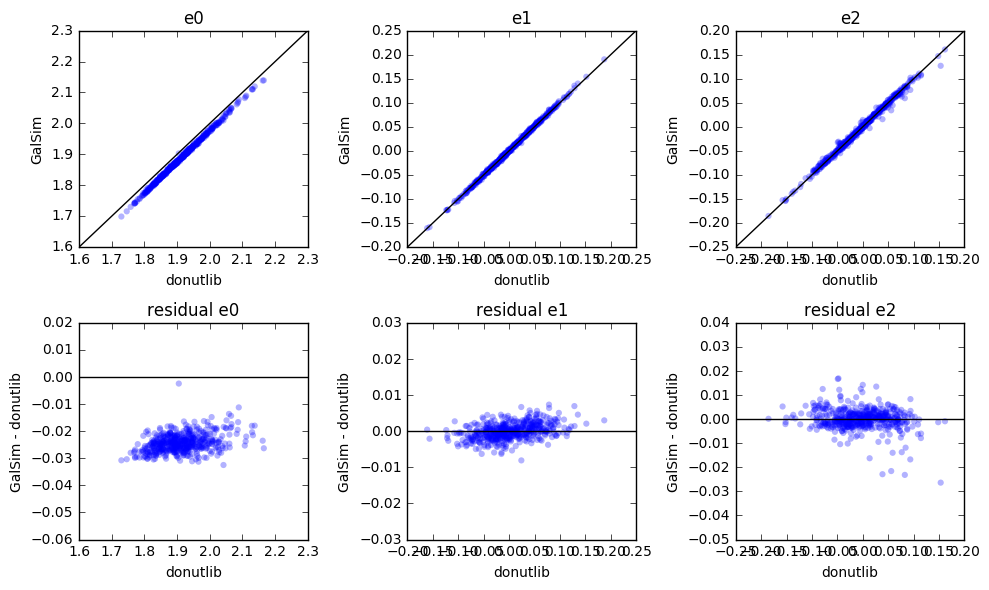

In [6]:
r0 = 0.2 # Pretty good seeing, corresponds to 0.7 arcsec at 700nm
gd = galsim.GaussianDeviate(12345)
z4 = 0.0  # no defocus
n = 500
donut_mom = np.empty((3, n), float)  # e0, e1, e2
galsim_mom = np.empty((3, n), float)
galsim_times = np.empty((n,), float)
donutlib_times = np.empty((n,), float)
with ProgressBar(n, ipython_widget=True) as bar:
    for i in range(n):
        # Add Gaussian-distributed aberrations
        zarray = np.empty((17,), float)
        gd.generate(zarray)
        zarray = [z4]+list(0.2*zarray)

        t0 = time.time()
        donut_image = donut_calc(zarray, r0, fast_donutmaker)
        donutlib_times[i] = time.time()-t0

        t0 = time.time()
        galsim_image = galsim_calc(zarray, r0)
        galsim_times[i] = time.time()-t0

        donut_hsm = moments(donut_image)
        galsim_hsm = moments(galsim_image)
        donut_mom[:, i] = donut_hsm
        galsim_mom[:, i] = galsim_hsm
        bar.update()

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i in range(3):
    axes[0, i].scatter(donut_mom[i], galsim_mom[i], alpha=0.3)
    axes[0, i].set_title("e{}".format(i))
    maxlims = np.max([axes[0, i].get_xlim(), axes[0, i].get_ylim()], axis=0)
    minlims = np.min([axes[0, i].get_xlim(), axes[0, i].get_ylim()], axis=0)
    lims = [minlims[0], maxlims[1]]
    axes[0, i].set_xlim(lims)
    axes[0, i].set_ylim(lims)
    axes[0, i].plot(axes[0, i].get_xlim(), axes[0, i].get_ylim(), c='k')
    axes[1, i].scatter(donut_mom[i], galsim_mom[i]-donut_mom[i], alpha=0.3)
    axes[1, i].set_title("residual e{}".format(i))
    axes[1, i].axhline(0.0, c='k')
for ax in axes[0]:
    ax.set_xlabel("donutlib")
    ax.set_ylabel("GalSim")
for ax in axes[1]:
    ax.set_xlabel("donutlib")
    ax.set_ylabel("GalSim - donutlib")
fig.tight_layout()
fig.show()

print("GalSim time per PSF = {:6.4f} s +/- {:6.4f} s".format(np.mean(galsim_times), np.std(galsim_times)/np.sqrt(n)))
print("Donutlib time per PSF = {:6.4f} s +/- {:6.4f} s".format(np.mean(donutlib_times), np.std(donutlib_times)/np.sqrt(n)))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"



GalSim time per PSF = 0.0103 s +/- 0.0000 s
Donutlib time per PSF = 0.1635 s +/- 0.0004 s


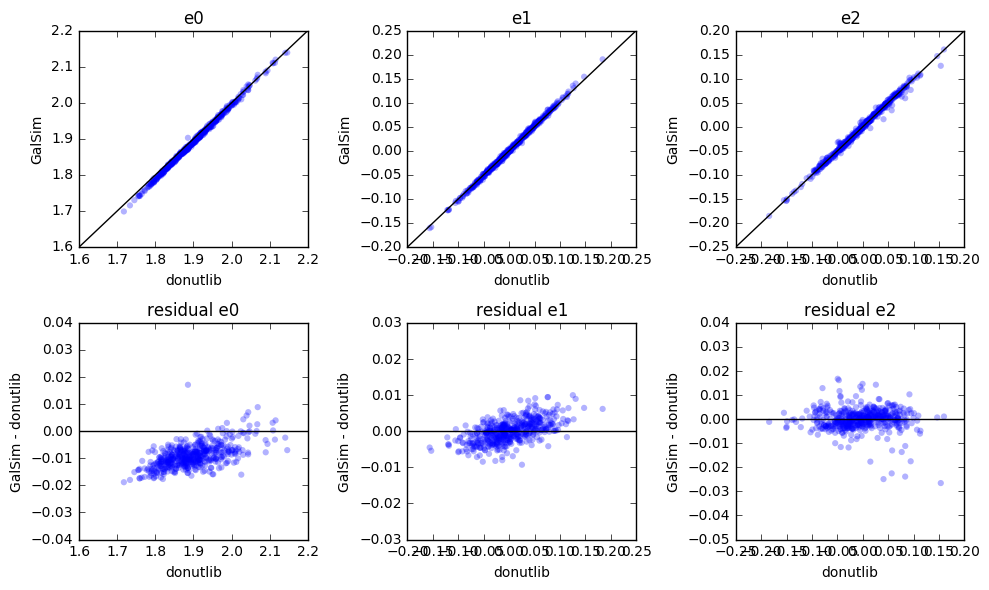

In [7]:
# Also compare "high accuracy" donutlib ellipticities to GalSim ellipticities.
r0 = 0.2 # Pretty good seeing, corresponds to 0.7 arcsec at 700nm
gd = galsim.GaussianDeviate(12345)
z4 = 0.0  # no defocus
n = 500
donut_mom = np.empty((3, n), float)  # e0, e1, e2
galsim_mom = np.empty((3, n), float)
galsim_times = np.empty((n,), float)
donutlib_times = np.empty((n,), float)
with ProgressBar(n, ipython_widget=True) as bar:
    for i in range(n):
        # Add Gaussian-distributed aberrations
        zarray = np.empty((17,), float)
        gd.generate(zarray)
        zarray = [z4]+list(0.2*zarray)

        # use "high accuracy" donutlib settings
        t0 = time.time()
        donut_image = donut_calc(zarray, r0, slow_donutmaker) 
        donutlib_times[i] = time.time()-t0

        t0 = time.time()
        galsim_image = galsim_calc(zarray, r0)
        galsim_times[i] = time.time()-t0

        donut_hsm = moments(donut_image)
        galsim_hsm = moments(galsim_image)
        donut_mom[:, i] = donut_hsm
        galsim_mom[:, i] = galsim_hsm
        bar.update()
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i in range(3):
    axes[0, i].scatter(donut_mom[i], galsim_mom[i], alpha=0.3)
    axes[0, i].set_title("e{}".format(i))
    maxlims = np.max([axes[0, i].get_xlim(), axes[0, i].get_ylim()], axis=0)
    minlims = np.min([axes[0, i].get_xlim(), axes[0, i].get_ylim()], axis=0)
    lims = [minlims[0], maxlims[1]]
    axes[0, i].set_xlim(lims)
    axes[0, i].set_ylim(lims)
    axes[0, i].plot(axes[0, i].get_xlim(), axes[0, i].get_ylim(), c='k')
    axes[1, i].scatter(donut_mom[i], galsim_mom[i]-donut_mom[i], alpha=0.3)
    axes[1, i].set_title("residual e{}".format(i))
    axes[1, i].axhline(0.0, c='k')
for ax in axes[0]:
    ax.set_xlabel("donutlib")
    ax.set_ylabel("GalSim")
for ax in axes[1]:
    ax.set_xlabel("donutlib")
    ax.set_ylabel("GalSim - donutlib")
fig.tight_layout()
fig.show()

print("GalSim time per PSF = {:6.4f} s +/- {:6.4f} s".format(np.mean(galsim_times), np.std(galsim_times)/np.sqrt(n)))
print("Donutlib time per PSF = {:6.4f} s +/- {:6.4f} s".format(np.mean(donutlib_times), np.std(donutlib_times)/np.sqrt(n)))